In [1]:
%pip install mne xgboost tensorflow scikit-learn pandas numpy matplotlib scipy tqdm


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: mne in c:\users\egeterzi\appdata\local\programs\python\python310\lib\site-packages (1.9.0)




[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score)
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_sleep_data(data_dir):                                              # Sleep-EDF icin veri setini yukluyoruz.
    file_pairs = []
    
    for f in os.listdir(data_dir):                                          # Dosya eslestirme islemi yapiyoruz.
        if f.endswith('0-PSG.edf'):
            hyp_file = f.replace('0-PSG.edf', 'C-Hypnogram.edf')
            if os.path.exists(os.path.join(data_dir, hyp_file)):            # Ayni konuya ait PSG ve Hypnogram dosyalarini eslestiriyoruz.
                file_pairs.append((                                         # PSG dosyasi sinyalleri tutar ve Hypnogram dosyasi labellari tutar.
                    os.path.join(data_dir, f),
                    os.path.join(data_dir, hyp_file)
                ))
    
    print(f"Bulunan PSG-Hypnogram çiftleri: {len(file_pairs)}")
    return file_pairs

In [4]:
from scipy.stats import skew, kurtosis, entropy

def extract_features_multi(data, sfreq):                                    # Sinyallere ait ozellikleri burada cikartiyoruz. data: np.array, shape (n_epochs, n_channels, n_times), sfreq: ornekleme hizi (Hz)

    feature_list = []   
    count=0                                                                 # Islenen toplam epoch sayisi.

    for epoch in data:                                                      # Her epoch icin dongu donuyoruz ve featurelarini cikartiyoruz.
        feats = []
        for ch_signal in epoch:                                             # Her kanal icin dongu

            mean = np.mean(ch_signal)                                       # Ortalama
            median = np.median(ch_signal)                                   # Medyan
            variance = np.var(ch_signal)                                    # Varyans
            min_val = np.min(ch_signal)                                     # Minimum deger
            max_val = np.max(ch_signal)                                     # Maksimum deger
            ptp = max_val - min_val                                         # Tepe araligi
            
            feats.extend([mean, median, variance, min_val, max_val, ptp])
            
            autocorr = np.correlate(ch_signal, ch_signal, mode='full')[len(ch_signal)-1:len(ch_signal)+5]       # Ilk 5 gecikme icin otokorelasyon degerleri
            feats.extend(autocorr[1:6])
            
            t = np.arange(len(ch_signal))                                   # Zaman vektoru
            slope = np.polyfit(t, ch_signal, 1)[0]                          # Egim hesabi
            feats.append(slope)
            
            hist, _ = np.histogram(ch_signal, bins=10, density=True)        # Entropi hesabi
            ent = entropy(hist)
            feats.append(ent)
            
            rms = np.sqrt(np.mean(ch_signal**2))                            # Root Mean Square frekans hesabi
            feats.append(rms)
            
            zcr = np.sum(np.diff(np.sign(ch_signal)) != 0) / len(ch_signal)     # Zero Crossing Rate hesabi
            feats.append(zcr)
            
            s = skew(ch_signal)                                            # Skewness ve kurtosis hesabi
            k = kurtosis(ch_signal)
            feats.extend([s, k])
            
            count+=1
        feature_list.append(feats)

    print (f"Özellik çıkarımı için toplam {count} epoch işleniyor...")
    return np.array(feature_list)

In [5]:
def create_dataset(file_pairs, epoch_duration=45.0):
    event_id = {
        'Sleep stage W': 0,                                                 # Uyanık
        'Sleep stage 1': 1,                                                 # Hafif Uyku
        'Sleep stage 2': 2,                                                 # Orta Uyku
        'Sleep stage 3': 3,                                                 # Derin Uyku
        'Sleep stage 4': 3,                                                 # Derin Uyku
        'Sleep stage R': 4                                                  # REM
    }
    X_list, y_list, meta_list = [], [], []

    for psg_file, hyp_file in file_pairs:                                           # Her PSG-Hypnogram dosya cifti icin yukleme dongusu
        raw = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
        annots = mne.read_annotations(hyp_file)
        raw.set_annotations(annots, emit_warning=False)

        events, found_event_id = mne.events_from_annotations(                       # Anotasyonlardan epoch eventlerini olusturuyorum.
            raw, event_id=event_id, 
            chunk_duration=epoch_duration
        )
        if len(events) == 0:
            continue

        wanted = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']     # Kullanilacak kanallari belirliyorum (EEG, EOG, EMG)
        use_chs = [ch for ch in raw.ch_names if ch in wanted]
        raw.pick_channels(use_chs)

        epochs = mne.Epochs(
            raw, events, event_id=found_event_id,
            tmin=0.0, 
            tmax=epoch_duration - 1/raw.info['sfreq'],                               # Her epochun sonu           
            baseline=None, preload=True
        )
        data = epochs.get_data()                                                    # Her epoch icin ozellik cikar ve ozellikleri ve etiketleri listeye ekliyorum.
        feats = extract_features_multi(data, raw.info['sfreq'])

        X_list.append(feats)
        y_list.append(epochs.events[:, -1])

        # Örnek metadata: dosya adı ve o dosyadan kaç epoch geldi
        meta_list.append({
            'file': os.path.basename(psg_file),
            'n_epochs': feats.shape[0]
        })

    X = np.vstack(X_list)                                                           # Tum dosyalarin ozelliklerini ve etiketlerini birlestiriyorum.
    y = np.hstack(y_list)
    return X, y, meta_list


In [6]:
def evaluate_model(y_true, y_pred, name):                                           # Temel metrikleri hesapliyorum
    acc = accuracy_score(y_true, y_pred)                                            # Isabet
    f1 = f1_score(y_true, y_pred, average='macro')                                  # f1 skoru
    kappa = cohen_kappa_score(y_true, y_pred)                                       # Cohen Kappa skoru
        
    print(f"\n{name} Performans:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("Sınıflandırma Raporu:")
    print(classification_report(y_true, y_pred,target_names=['Wake', 'N1', 'N2', 'N3', 'REM']))
        
    cm = confusion_matrix(y_true, y_pred)                                           # Confusion matrix gosteriyorum.
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ['Wake', 'N1', 'N2', 'N3', 'REM'])
    plt.yticks(tick_marks, ['Wake', 'N1', 'N2', 'N3', 'REM'])
    plt.ylabel('Gerçek')
    plt.xlabel('Tahmin')
    plt.show()
        
    return acc, f1, kappa
    

def train_rf_model(X_train, y_train, X_test, y_test):                               # Random Forest egitimi
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)                                                        # Model egitimi ve tahmini.
    rf_pred = rf.predict(X_test)

    rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")                   # Modelin basarimini hesapliyorum.
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(rf.feature_importances_)), rf.feature_importances_)          # Modelin ozelliklerinin onem grafigini cikartiyorum.
    plt.title('Random Forest - Özellik Önemleri')
    plt.xlabel('Önem Skoru')
    plt.tight_layout()
    plt.show()

    return rf,rf_metrics

def train_xgb_model(X_train, y_train, X_test, y_test):                              # XGBoost modeli egitimi

    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)                                                 # Model egitimi ve tahmini.
    xgb_pred = xgb_model.predict(X_test)

    xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")
    

    return xgb_model,xgb_metrics


def train_lstm_model(X_train, y_train, X_test, y_test):                             # Model egitimi ve tahmini.

    timesteps = 1                                                                   # Bu timesteps'i dusurunce daha iyi sonuc elde ettim.
    features_per_timestep = X_train.shape[1]
    
    def reshape_data(X):                                                            # Veriyi yeniden sekillendiriyorum, 3D olacak sekilde.
        samples = X.shape[0]
        X_reshaped = np.zeros((samples, timesteps, features_per_timestep))
        
        for i in range(samples):
            for j in range(timesteps):
                start = j * features_per_timestep
                end = start + features_per_timestep
                X_reshaped[i, j] = X[i, start:end]
        
        return X_reshaped
    
    X_train_lstm = reshape_data(X_train)                                    
    X_test_lstm = reshape_data(X_test)
    
    model = Sequential([                                                            # Model tanimi
        LSTM(128, input_shape=(timesteps, features_per_timestep), return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(5, activation='softmax')                                              # Kodum duzgun calismiyordu softmax ve compile adimlarini ChatGPT'den aldim.
    ])
    
    model.compile(                                                                                                                                    
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )


    history = model.fit(                                                            # Egitim
        X_train_lstm, y_train,
        epochs=20,
        batch_size=64,
        validation_split=0.2,
        verbose=1
    )
    
    lstm_pred = np.argmax(model.predict(X_test_lstm), axis=1)                       # Test
    lstm_metrics = evaluate_model(y_test, lstm_pred, "LSTM")
    
    plt.figure(figsize=(12, 4))                                                     # Egitim sonuclari grafikleri
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return model, lstm_metrics

def train_mlp_model(X_train, y_train, X_test, y_test):                              # Bir multi layer perceptron kullandim.
    model = Sequential([                                                            # 3 gizli katman ve Dropout ile tanimladim.
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(5, activation='softmax')
    ])
    
    model.compile(                                                                  # Modeli derliyorum.
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    

    early_stop = tf.keras.callbacks.EarlyStopping(                                  # Early stopping ile dogrulama kaybi degismezse 5 epoch sonra egitimi durduruyorum.
        monitor='val_loss', 
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(                                                            # Modeli egitiyorum.
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    mlp_pred = np.argmax(model.predict(X_test), axis=1)                             # Model sonuclarini aliyoruz ve grafigini cikartiyoruz.
    mlp_metrics = evaluate_model(y_test, mlp_pred, "MLP")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Model Doğruluğu')
    plt.ylabel('Doğruluk')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Model Kaybı')
    plt.ylabel('Kayıp')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return model, mlp_metrics


In [7]:
def my_standard_scaler(X):              # Verilerimi 0-1 arasina standartize ediyorum.
    mean = np.mean(X, axis=0)           # Her sutunun ortalamasi
    std = np.std(X, axis=0)             # Her sutunun standart sapmasi
    X_scaled = (X - mean) / std         # Standardizasyon formulu
    return X_scaled

Bulunan PSG-Hypnogram çiftleri: 10
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
1691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1691 events and 4500 original time points ...
0 bad epochs dropped
Özellik çıkarımı için toplam 6764 epoch işleniyor...
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
1820 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1820 events and 4500 orig

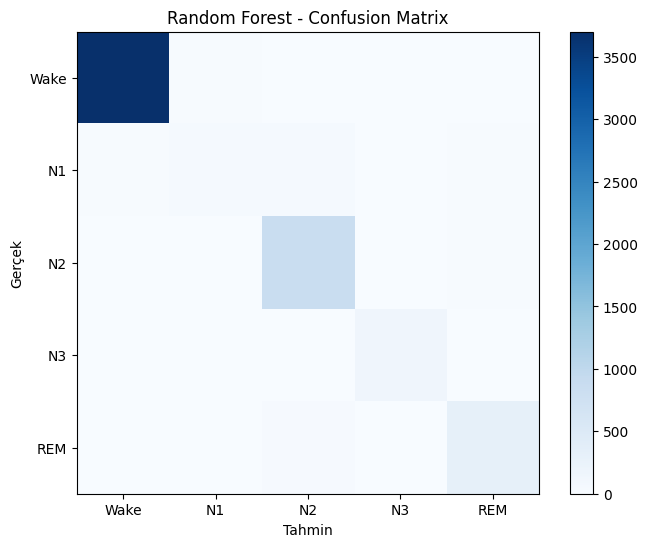

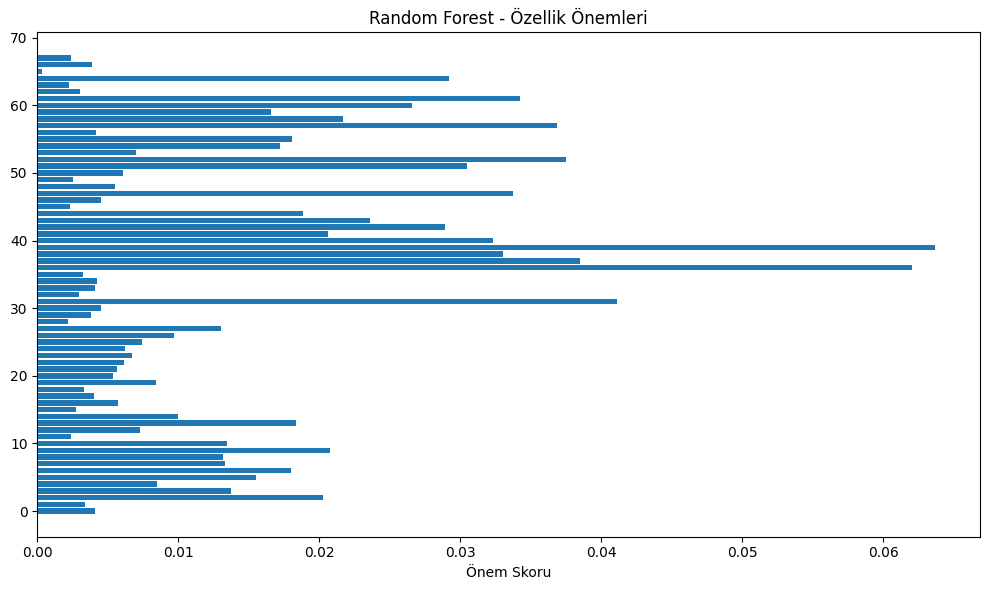


XGBoost Performans:
Accuracy: 0.9586
Macro F1: 0.8353
Cohen's Kappa: 0.9118
Sınıflandırma Raporu:
              precision    recall  f1-score   support

        Wake       0.99      0.99      0.99      3726
          N1       0.65      0.35      0.46       154
          N2       0.90      0.95      0.92       910
          N3       0.92      0.93      0.92       162
         REM       0.88      0.89      0.88       361

    accuracy                           0.96      5313
   macro avg       0.87      0.82      0.84      5313
weighted avg       0.96      0.96      0.96      5313



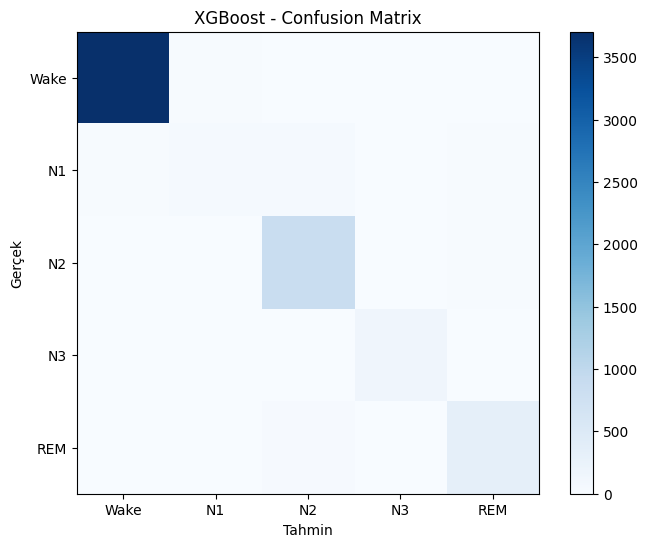

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7885 - loss: 0.9627 - val_accuracy: 0.9145 - val_loss: 0.2663
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9099 - loss: 0.2701 - val_accuracy: 0.9319 - val_loss: 0.1820
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9320 - loss: 0.1914 - val_accuracy: 0.9355 - val_loss: 0.1671
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9368 - loss: 0.1786 - val_accuracy: 0.9407 - val_loss: 0.1564
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9416 - loss: 0.1551 - val_accuracy: 0.9460 - val_loss: 0.1504
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9461 - loss: 0.1461 - val_accuracy: 0.9468 - val_loss: 0.1501
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9427 - loss: 0.1500 - val_accuracy: 0.9435 - val_loss: 0.1505
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9502 - loss: 0.1390 - val_accuracy: 0.

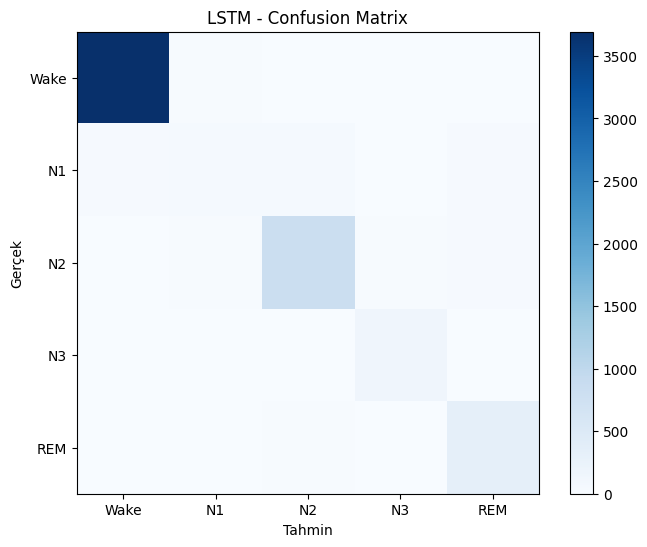

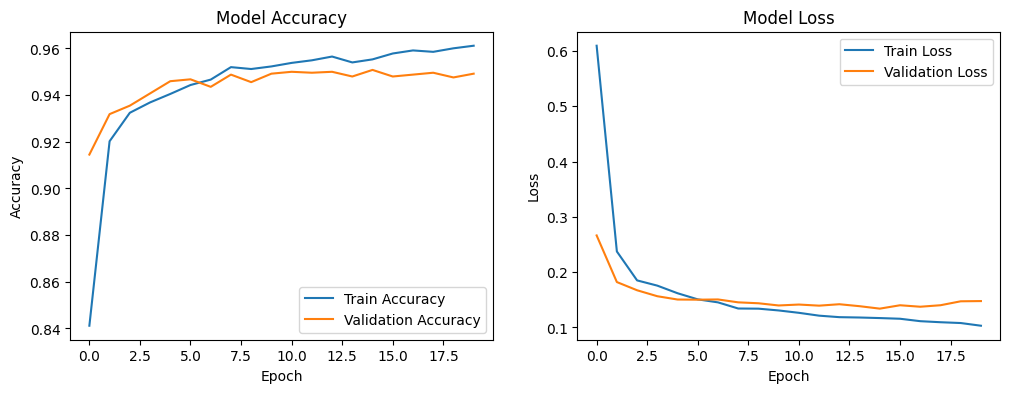

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7812 - loss: 0.6645 - val_accuracy: 0.9153 - val_loss: 0.2432
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9120 - loss: 0.2617 - val_accuracy: 0.9327 - val_loss: 0.1867
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9271 - loss: 0.2048 - val_accuracy: 0.9403 - val_loss: 0.1688
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9280 - loss: 0.2064 - val_accuracy: 0.9403 - val_loss: 0.1627
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9387 - loss: 0.1864 - val_accuracy: 0.9456 - val_loss: 0.1578
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9333 - loss: 0.1866 - val_accuracy: 0.9407 - val_loss: 0.1633
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9386 - loss: 0.1710 - val_accuracy: 0.9431 - val_loss: 0.1557
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9460 - loss: 0.1565 - val_accuracy: 0.

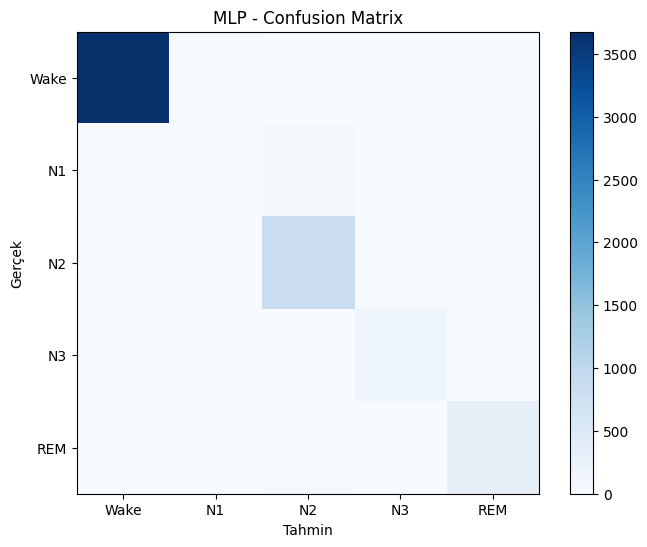

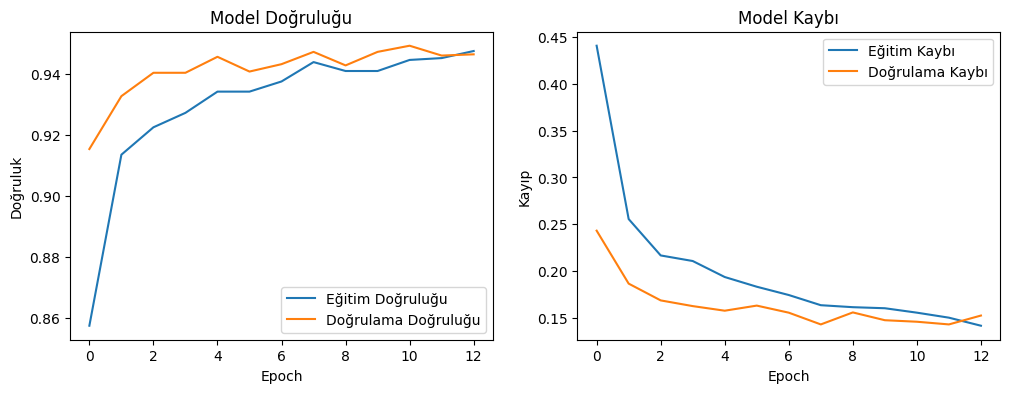

Modeller başarıyla kaydedildi!

MODEL PERFORMANS KARŞILAŞTIRMASI:
RF: Accuracy=0.9546395633352155, F1=0.8280512131048324, Kappa=0.9032356356345765
XGB: Accuracy=0.9585921325051759, F1=0.8353441906369955, Kappa=0.9117885981295434
LSTM: Accuracy=0.9474872953133823, F1=0.8052102137717299, Kappa=0.8884847624948505
MLP: Accuracy=0.9435347261434218, F1=0.7984616778206135, Kappa=0.8806132698361813


In [8]:
def main():
    DATA_DIR = "./Sleep_EDF_Training_Data"                                                          # Egitim verisinin oldugu yer.
    
    file_pairs = load_sleep_data(DATA_DIR)                                                          # Uyku verilerini okuyoruz.
    
    X, y, metadata = create_dataset(file_pairs, epoch_duration=45.0)                                # Modelin verisetini cikartiyoruz.
    print("X shape:", getattr(X, "shape", None), "  y shape:", getattr(y, "shape", None))
    print(f"\nOluşturulan veri seti boyutu: {X.shape}")
    print(f"Sınıf dağılımı: {pd.Series(y).value_counts()}")
    
    X_scaled = my_standard_scaler(X)                                                                # Veriyi olceklendiriyoruz.
    

    X_train, X_test, y_train, y_test = train_test_split(                                            # Egitim ve test verisini ayiriyoruz.
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    
    rf_model, rf_metrics = train_rf_model(X_train, y_train, X_test, y_test)                         # Modelleri egitiyoruz ve degerlendiriyoruz.
    xgb_model, xgb_metrics = train_xgb_model(X_train, y_train, X_test, y_test)
    lstm_model, lstm_metrics = train_lstm_model(X_train, y_train, X_test, y_test)
    mlp_model, mlp_metrics = train_mlp_model(X_train, y_train, X_test, y_test)

    import joblib                                                                                   # Egittigimiz modelleri kaydediyoruz. (Burayi da ChatGPT'den aldim.)
    from tensorflow.keras.models import save_model
    

    joblib.dump(rf_model, 'random_forest_model.joblib')
    joblib.dump(xgb_model, 'xgboost_model.joblib')
    lstm_model.save('lstm_model.h5')
    mlp_model.save('mlp_model.h5')
    
    print("Modeller başarıyla kaydedildi!")

    rf_acc, rf_f1, rf_kappa = rf_metrics                                                            # En sonda toplu performans karsilastirmasi yapiyoruz.
    xgb_acc, xgb_f1, xgb_kappa = xgb_metrics
    lstm_acc, lstm_f1, lstm_kappa = lstm_metrics
    mlp_acc, mlp_f1, mlp_kappa = mlp_metrics

    print("\nMODEL PERFORMANS KARŞILAŞTIRMASI:")
    print(f"RF: Accuracy={rf_acc}, F1={rf_f1}, Kappa={rf_kappa}")
    print(f"XGB: Accuracy={xgb_acc}, F1={xgb_f1}, Kappa={xgb_kappa}")
    print(f"LSTM: Accuracy={lstm_acc}, F1={lstm_f1}, Kappa={lstm_kappa}")
    print(f"MLP: Accuracy={mlp_acc}, F1={mlp_f1}, Kappa={mlp_kappa}")
    
if __name__ == "__main__":
    main()